<a href="https://colab.research.google.com/github/Dev-180Memes/deepfake-detection/blob/main/Video_Classifier_%7C_Pytorch_%7C_LSTM_%7C_CNN(resnet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
reubensuju_celeb_df_v2_path = kagglehub.dataset_download('reubensuju/celeb-df-v2')

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import json
from torch.utils.data.sampler import WeightedRandomSampler

# DataSet Creation

In [ ]:
df = pd.read_csv('/kaggle/input/celeb-df-v2/List_of_testing_videos.txt',delimiter=' ')
df.shape

(517, 2)

In [ ]:
# TO SPLIT THE DATA EVENLY
def create_dataset_splits(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):
    real_videos = []
    fake_videos = []

    # Collect real videos
    for folder in ['Celeb-real', 'YouTube-real']:
        folder_path = os.path.join(base_path, folder)
        videos = [os.path.join(folder, f) for f in os.listdir(folder_path) if f.endswith('.mp4')]
        real_videos.extend(videos)


    # Collect fake videos
    fake_folder = os.path.join(base_path, 'Celeb-synthesis')
    fake_videos = [os.path.join('Celeb-synthesis', f) for f in os.listdir(fake_folder) if f.endswith('.mp4')]

    #REMOVE AFTER TESTING
    real_videos = real_videos[:500]
    fake_videos = fake_videos[:500]

    class_counts = {
        'real': len(real_videos),
        'fake': len(fake_videos)
    }
    print(f"Real videos: {class_counts['real']}, Fake videos: {class_counts['fake']}")

    # Split each class separately
    splits_dict = {split: [] for split in ['train', 'val', 'test']}

    for videos, label in [(real_videos, 'real'), (fake_videos, 'fake')]:
        train_split, temp = train_test_split(videos, train_size=train_size, random_state=seed)
        relative_val_size = val_size / (val_size + test_size)
        val_split, test_split = train_test_split(temp, train_size=relative_val_size, random_state=seed)

        splits_dict['train'].extend(train_split)
        splits_dict['val'].extend(val_split)
        splits_dict['test'].extend(test_split)

    with open(os.path.join(output_path, 'splits.json'), 'w') as f:
        json.dump({
            'splits': splits_dict,
            'class_counts': class_counts
        }, f)

    return splits_dict, class_counts

In [ ]:
#A PYTORCH DATASET THAT RETRIEVES THAT VIDEO DATA
class VideoDatasetSplit(Dataset):
    def __init__(self, base_path, split_path, split='train', sequence_length=15, transform=None):
        self.base_path = Path(base_path)
        self.sequence_length = sequence_length
        self.transform = transform

        with open(os.path.join(split_path, 'splits.json'), 'r') as f:
            data = json.load(f)
            self.videos = data['splits'][split]
            self.class_counts = data['class_counts']

    def get_sampler(self):
        weights = []
        max_samples = max(self.class_counts.values())

        for video_path in self.videos:
            is_fake = 'synthesis' in video_path
            count = self.class_counts['fake'] if is_fake else self.class_counts['real']
            weight = max_samples / count
            weights.append(weight)

        return WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))

    def __getitem__(self, idx):
        video_path = self.videos[idx]
        label = 1 if 'synthesis' in video_path else 0  # 1 for fake, 0 for real

        frames = self.load_video(os.path.join(self.base_path, video_path))
        if self.transform:
            frames = torch.stack([self.transform(frame) for frame in frames])

        return frames, label

    def __len__(self):
        return len(self.videos)

    def load_video(self, video_path):
        frames = []
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        # print("TOTAL FRAMES: ",total_frames)
        indices = np.linspace(0, total_frames-1, self.sequence_length, dtype=int)

        for frame_idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame)
            else:
                frames.append(np.zeros(frames[-1].shape, dtype=np.uint8))
            # print(frames[-1].shape)

        cap.release()
        # print("Number of FRAMES: ",len(frames))
        return np.stack(frames)

def create_dataloaders(base_path, output_path,dim, batch_size=4, sequence_length=10):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((dim, dim)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    splits_dict, class_counts = create_dataset_splits(base_path, output_path)

    train_dataset = VideoDatasetSplit(base_path, output_path, 'train', sequence_length, transform)
    val_dataset = VideoDatasetSplit(base_path, output_path, 'val', sequence_length, transform)
    test_dataset = VideoDatasetSplit(base_path, output_path, 'test', sequence_length, transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.get_sampler(),
        num_workers=4,
        pin_memory=True
    )

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader, class_counts

In [ ]:
train_loader, val_loader, test_loader, class_counts = create_dataloaders('/kaggle/input/celeb-df-v2','/kaggle/working/',dim=224,batch_size=16,sequence_length=15)

Real videos: 500, Fake videos: 500


## Visualizing

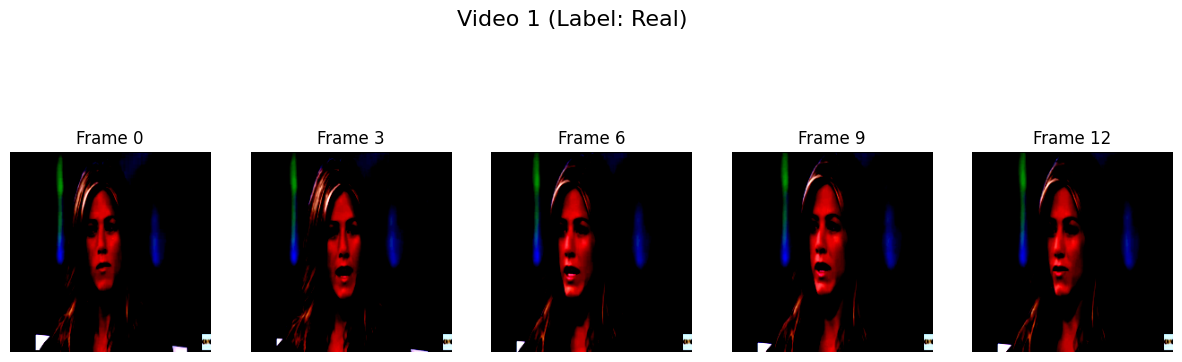

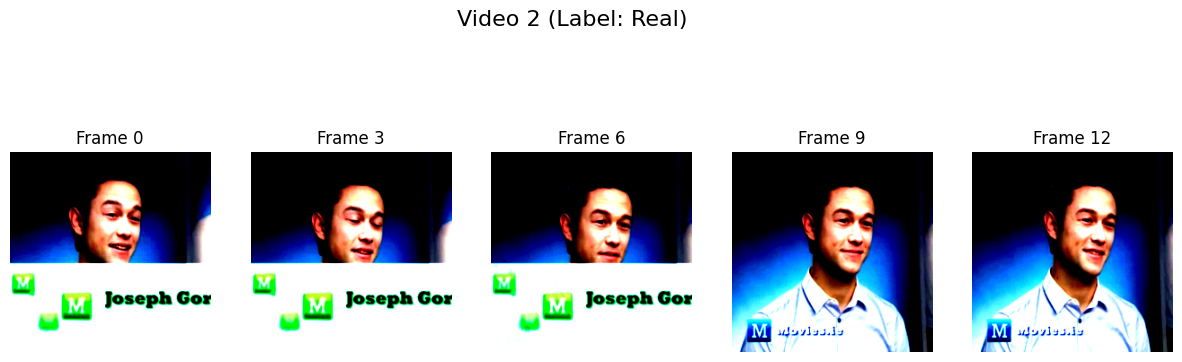

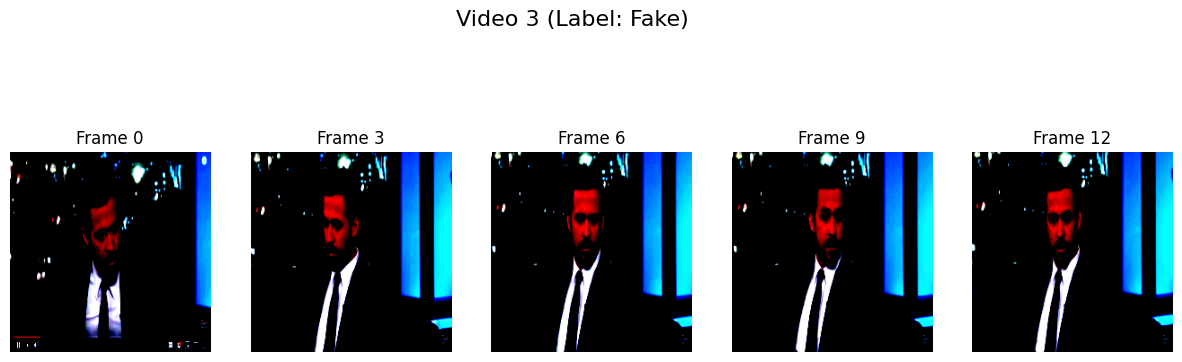

In [ ]:
import matplotlib.pyplot as plt

def visualize_frames(data_loader, num_videos=2, num_frames=5):
    """
    Visualizes frames from videos in a batch.
    Args:
        data_loader: DataLoader object containing the video dataset.
        num_videos: Number of videos to visualize from the batch.
        num_frames: Number of frames to visualize per video.
    """
    # Fetch one batch of data
    batch = next(iter(data_loader))
    videos, labels = batch  # videos: [batch_size, sequence_length, C, H, W], labels: [batch_size]

    videos = videos[:num_videos]  # Take the first few videos
    labels = labels[:num_videos]

    for i, video in enumerate(videos):
        # Convert video tensor to numpy array and move channel to the last dimension
        video = video.permute(0, 2, 3, 1).numpy()  # Shape: [sequence_length, H, W, C]

        # Plot frames
        fig, axs = plt.subplots(1, num_frames, figsize=(15, 5))
        fig.suptitle(f"Video {i + 1} (Label: {'Fake' if labels[i] == 1 else 'Real'})", fontsize=16)

        for j in range(num_frames):
            frame_idx = int(j * (len(video) / num_frames))  # Select evenly spaced frames
            axs[j].imshow(video[frame_idx])
            axs[j].axis('off')
            axs[j].set_title(f"Frame {frame_idx}")

        plt.show()


visualize_frames(train_loader, num_videos=3, num_frames=5)


# Model Creation

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import wandb
import torch.nn.functional as F

class DynamicVideoClassifier(nn.Module):
    def __init__(self, backbone='resnet18', hidden_size=512, num_layers=2, dropout=0.3):
        super().__init__()

        # List of valid backbones
        self.valid_backbones = [
            'vgg16', 'resnet18', 'resnet50', 'densenet121', 'mobilenet_v2', 'inception_v3'
        ]

        # Ensure the provided backbone is valid
        if backbone not in self.valid_backbones:
            raise ValueError(f"Invalid backbone. Choose from {', '.join(self.valid_backbones)}")

        # Load the CNN backbone and get feature size
        self.backbone = getattr(models, backbone)(pretrained=True)
        avg_size = 1
        # print(self.backbone)
        # Adjust feature size based on the model architecture

        if backbone in ['resnet18', 'resnet50']:
            self.feature_size = self.backbone.fc.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove fully connected layer
        elif backbone == 'vgg16':
            self.feature_size = self.backbone.classifier[0].in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1][0])  # Remove classifier
            avg_size = 7
        elif backbone == 'densenet121':
            self.feature_size = self.backbone.classifier.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        elif backbone == 'mobilenet_v2':
            self.feature_size = self.backbone.classifier[1].in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier
        elif backbone == 'inception_v3':
            self.feature_size = self.backbone.AuxLogits.fc.in_features
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])  # Remove classifier

        self.avg_pool = nn.AdaptiveAvgPool2d((avg_size, avg_size))  # Applies average pooling over spatial dimensions (H, W)
        # LSTM for temporal features
        self.lstm = nn.LSTM(
            input_size=self.feature_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        # self.attention = nn.MultiheadAttention(hidden_size,2, dropout=dropout, batch_first=True)
        # self.layer_norm = nn.LayerNorm(hidden_size)

        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()


        # CNN feature extraction
        x = x.view(-1, c, h, w)
        # print('Input X: ',x.shape)
        x = self.backbone(x)
        x = self.avg_pool(x)
        # print('Output from CNN X: ',x.shape)
        x = x.view(batch_size, seq_len, -1)  # Reshape to (batch_size, seq_len, feature_size)

        # LSTM processing
        # print('Input LSTM: ',x.shape)
        lstm_out, _ = self.lstm(x)
        # print('Output LSTM: ',lstm_out.shape)

        # Attention mechanism
        # print('Input Att: ',lstm_out.shape)
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)
        attended_features = torch.sum(attention_weights * lstm_out, dim=1)
        # print('Output Att: ',attended_features.shape)
        # attended_features, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
        # attended_features = self.layer_norm(lstm_out + attended_features)
        # attended_features = torch.mean(attended_features, dim=1)  # Average across sequence
        # print('Output Att: ',attended_features.shape)
        # Classification
        output = self.classifier(attended_features)
        # print("Output: ",output.shape)
        # print("SE: ",output.squeeze().shape)
        return output.squeeze()


In [ ]:
class VideoTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        learning_rate=1e-4,
        weight_decay=0.01,
        epochs=10,
        device='cuda',
        use_wandb=False
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.epochs = epochs
        self.use_wandb = use_wandb
        self.metrics = []

        # Loss function with class weighting
        pos_weight = self._calculate_pos_weight()
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        # Optimizer and scheduler
        self.optimizer = AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay
        )
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=epochs,
            eta_min=learning_rate/100
        )

        if use_wandb:
            self._init_wandb()

    def _calculate_pos_weight(self):
        total_pos = sum(1 for _, label in self.train_loader.dataset if label == 1)
        total_neg = len(self.train_loader.dataset) - total_pos
        return torch.tensor([total_neg / total_pos]).to(self.device)

    def _init_wandb(self):
        wandb.init(
            project="deepfake-detection",
            config={
                "architecture": self.model.__class__.__name__,
                "backbone": "resnet50",
                "epochs": self.epochs,
                "batch_size": self.train_loader.batch_size,
            }
        )

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        predictions, targets = [], []

        for batch_idx, (videos, labels) in enumerate(self.train_loader):
            videos, labels = videos.to(self.device), labels.to(self.device).float()

            self.optimizer.zero_grad()
            outputs = self.model(videos)
            # print(outputs.shape)
            # print(labels.shape)
            loss = self.criterion(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            running_loss += loss.item()
            predictions.extend(outputs.detach().cpu().numpy())
            targets.extend(labels.cpu().numpy())


        metrics = self._calculate_metrics(predictions, targets)
        metrics['loss'] = running_loss / len(self.train_loader)
        print("Train Epoch Loss: ",metrics['loss'])
        return metrics

    def validate(self,mode='val'):
        self.model.eval()
        running_loss = 0.0
        predictions, targets = [], []
        loader = self.val_loader
        if mode == 'test':
            loader = self.test_loader
        with torch.no_grad():
            for videos, labels in loader:
                videos, labels = videos.to(self.device), labels.to(self.device).float()
                outputs = self.model(videos)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                predictions.extend(outputs.cpu().numpy())
                targets.extend(labels.cpu().numpy())
        # REMOVE
        # print("Validation:")
        # print((np.array(predictions) > 0.5).astype(int))
        # print(targets)
        metrics = self._calculate_metrics(predictions, targets)
        if mode == 'val':
            metrics['loss'] = running_loss / len(self.val_loader)
            print("Validation Epoch Loss: ",metrics['loss'])
        return metrics

    def _calculate_metrics(self, predictions, targets):
        predictions = np.array(predictions)
        targets = np.array(targets)

        # Convert probabilities to binary predictions
        binary_preds = (predictions > 0.5).astype(int)

        # Calculate metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            targets, binary_preds, average='binary'
        )
        auc = roc_auc_score(targets, predictions)

        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    def train(self):
        best_val_auc = 0
        for epoch in range(self.epochs):
            train_metrics = self.train_epoch()
            val_metrics = self.validate()
            self.scheduler.step()

            if val_metrics['auc'] > best_val_auc:
                best_val_auc = val_metrics['auc']
                torch.save(self.model.state_dict(), 'best_model.pth')

            metrics = {
                'train': train_metrics,
                'val': val_metrics,
                'epoch': epoch + 1
            }

            self._log_metrics(metrics)
        print("[Running on TEST SET]")
        print('-'*80)
        test_metrics = self.validate('test')
        print(test_metrics)

    def _log_metrics(self, metrics):
        print(f"Epoch {metrics['epoch']}/{self.epochs}")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} - ", end="")
            phase_metrics = metrics[phase]
            metric_str = " | ".join(
                f"{k}: {v:.4f}" for k, v in phase_metrics.items()
            )
            print(metric_str)
        # WRITE HERE
        self.metrics.append(metrics)
        # Weight and Biases
        if self.use_wandb:
            wandb.log({
                f"{phase}_{k}": v
                for phase in ['train', 'val']
                for k, v in metrics[phase].items()
            })

In [ ]:
def train_model(train_loader, val_loader,test_loader, config=None):
    valid_backbones = [
            'vgg16', 'resnet18', 'resnet50', 'densenet121', 'mobilenet_v2'
    ]
    if config is None:
        config = {
            'backbone': valid_backbones[2],
            'hidden_size': 512,
            'num_layers': 2,
            'dropout': 0.3,
            'learning_rate': 7.278416345265247e-05,
            'weight_decay': 0.01,
            'epochs': 10,
            'device': 'cuda' if torch.cuda.is_available() else 'cpu',
            'use_wandb': False
        }

    model = DynamicVideoClassifier(
        backbone=config['backbone'],
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )
    print(model)
    #Utilize Parallel computing
    model = torch.nn.DataParallel(model)

    trainer = VideoTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader= test_loader,
        learning_rate=config['learning_rate'],
        weight_decay=config['weight_decay'],
        epochs=config['epochs'],
        device=config['device'],
        use_wandb=config['use_wandb']
    )

    trainer.train()
    return model , trainer.metrics

In [ ]:
 model , metrics = train_model(train_loader, val_loader,test_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s] 


DynamicVideoClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

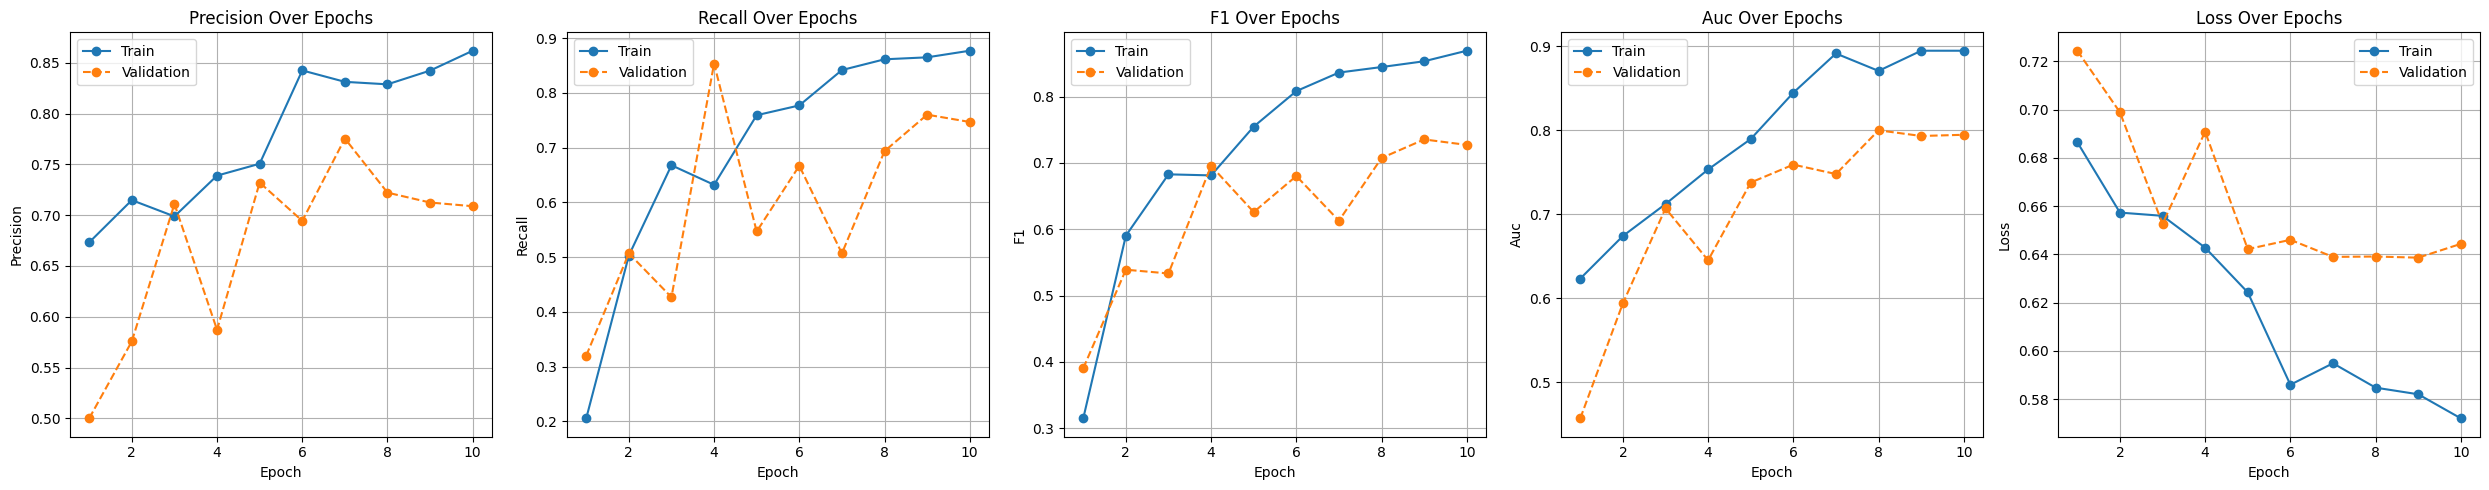

In [ ]:
import matplotlib.pyplot as plt

def visualize_metrics(metrics):
    """
    Visualizes training and validation metrics over epochs.

    Args:
        metrics (list of dict): List containing dictionaries of training and validation metrics per epoch.
    """
    # Extract epochs, training, and validation metrics
    epochs = [entry['epoch'] for entry in metrics]
    train_metrics = {key: [entry['train'][key] for entry in metrics] for key in metrics[0]['train']}
    val_metrics = {key: [entry['val'][key] for entry in metrics] for key in metrics[0]['val']}

    # List of metric names
    metric_names = list(train_metrics.keys())

    # Set up the plots
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
    if num_metrics == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one plot

    for i, metric_name in enumerate(metric_names):
        axes[i].plot(epochs, train_metrics[metric_name], label='Train', marker='o')
        axes[i].plot(epochs, val_metrics[metric_name], label='Validation', marker='o', linestyle='--')
        axes[i].set_title(f"{metric_name.capitalize()} Over Epochs")
        axes[i].set_xlabel("Epoch")
        axes[i].set_ylabel(metric_name.capitalize())
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage

visualize_metrics(metrics)
